In [3]:
import logging
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

data=pd.read_csv("feature_frames.csv")
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
order_sizes = data.groupby('order_id').size()
orders_with_5_or_more_products = order_sizes[order_sizes >= 5].index
filtered_data = data[data['order_id'].isin(orders_with_5_or_more_products)]
filtered_data = data[data['user_order_seq'] > 5]
df = pd.DataFrame(filtered_data)
df['created_at'] = pd.to_datetime(df['created_at'])
df['order_date'] = pd.to_datetime(df['order_date'])

def get_season(month):
    if month in [12, 1, 2]:
        return 1  # winter
    elif month in [3, 4, 5]:
        return 2  # spring
    elif month in [6, 7, 8]:
        return 3  # summer
    else:
        return 4  # Outumn


df['season'] = df['order_date'].dt.month.apply(get_season)
df['day_of_week'] = df['order_date'].dt.dayofweek
df['is_weekend'] = df['order_date'].dt.dayofweek >= 5
df['hour_of_day'] = df['order_date'].dt.hour
variables_categoricas = ['product_type', 'vendor']
variables_binarias = ['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular','is_weekend']

for columna in variables_categoricas:
    frecuencias = df[columna].value_counts().to_dict()
    df[columna + '_freq'] = df[columna].map(frecuencias)

for columna in variables_binarias:
    df[columna] = df[columna].astype(int)

X = df.drop(['variant_id', 'order_id', 'user_id', 'product_type','vendor','created_at', 'order_date', 'outcome'], axis=1)
X = pd.concat([X, df[['day_of_week', 'is_weekend', 'hour_of_day']]], axis=1)
y = df['outcome']

logging.info("X first rows:\n%s", X.head().to_string())
   







2024-02-16 10:54:01,205 - INFO - X first rows:
    user_order_seq  ordered_before  abandoned_before  active_snoozed  set_as_regular  normalised_price  discount_pct  global_popularity  count_adults  count_children  count_babies  count_pets  people_ex_baby  days_since_purchase_variant_id  avg_days_to_buy_variant_id  std_days_to_buy_variant_id  days_since_purchase_product_type  avg_days_to_buy_product_type  std_days_to_buy_product_type  season  day_of_week  is_weekend  hour_of_day  product_type_freq  vendor_freq  day_of_week  is_weekend  hour_of_day
7               13               0                 0               0               0          0.081052      0.053512           0.038462           2.0             0.0           0.0         0.0             2.0                            33.0                        42.0                   31.134053                              30.0                          30.0                      24.27618       4            1           0            0            

NON-LINEAR MODELS

first, let's check which variables have zero weight with lasso.


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
parametros = {'alpha': np.logspace(-4, -0.5, 30)}
lasso = Lasso()
grid_search = GridSearchCV(lasso, parametros, cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
logging.info(f"Best alpha: {best_alpha}")

lasso_optimo = Lasso(alpha=best_alpha)
lasso_optimo.fit(X_train, y_train)

coeficients = pd.Series(lasso_optimo.coef_, index=X.columns)
variables_with_zero = coeficients[coeficients == 0].index.tolist()

logging.info(f"Variables with 0 weight: {variables_with_zero}")


2024-02-16 10:54:39,649 - INFO - Best alpha: 9.999999999999999e-05
2024-02-16 10:54:39,941 - INFO - Variables with 0 weight: ['active_snoozed', 'normalised_price', 'discount_pct', 'count_adults', 'count_babies', 'day_of_week', 'hour_of_day', 'day_of_week', 'is_weekend', 'hour_of_day']


In [11]:
variables_con_peso_cero = ['active_snoozed', 'normalised_price', 'discount_pct', 'count_adults', 'count_babies', 'day_of_week', 'hour_of_day', 'is_weekend']
df_new = df.drop(columns=variables_con_peso_cero)
X = df_new.drop(['variant_id', 'order_id', 'user_id', 'product_type','vendor','created_at', 'order_date', 'outcome'], axis=1)
X = pd.concat([X, df[['day_of_week', 'is_weekend', 'hour_of_day']]], axis=1)
y = df['outcome']
X_filtrado, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

DECISION TREE:


2024-02-16 11:51:07,238 - INFO - Best parameters: {'max_depth': 10}


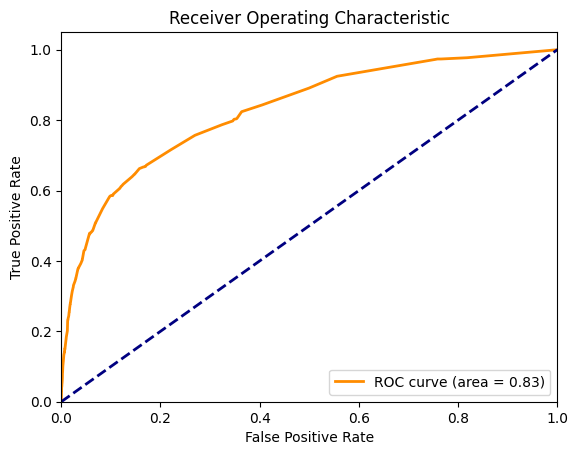

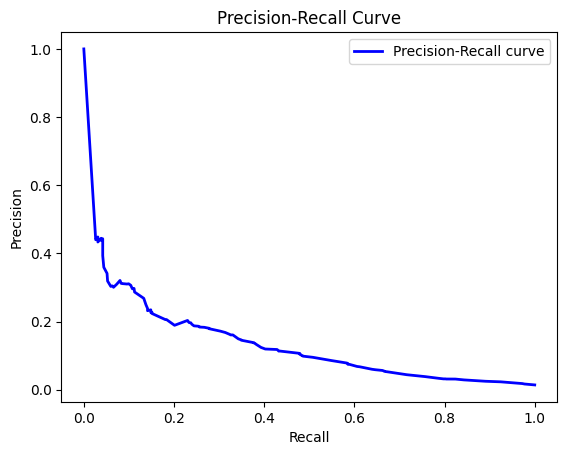

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

param_grid = {
    'max_depth': [None, 10, 20, 30, 40]  
}
clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_filtrado, y_train)
best_params = grid_search.best_params_
logging.info(f"Best parameters: {best_params}")
clf_optimo = DecisionTreeClassifier(max_depth=best_params['max_depth'], random_state=42)
clf_optimo.fit(X_filtrado, y_train)

y_scores = clf_optimo.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_scores)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

y_pred = clf_optimo.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
logging.info(f"Confusion Matrix:\n{conf_matrix}")

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
logging.info(f"Metrics:\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

auc_precision_recall = auc(recall, precision)
logging.info(f"AUC for Precision-Recall Curve: {auc_precision_recall:.2f}")


LET'S DO FIRST A RANDOM FOREST:

2024-02-16 12:05:25,550 - INFO - Best parameters: {'max_depth': 10, 'n_estimators': 100}


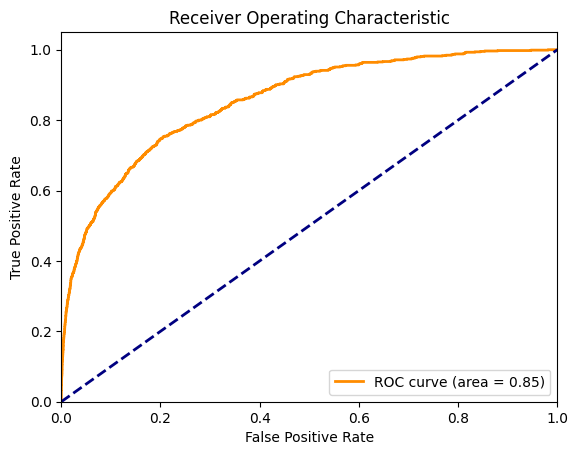

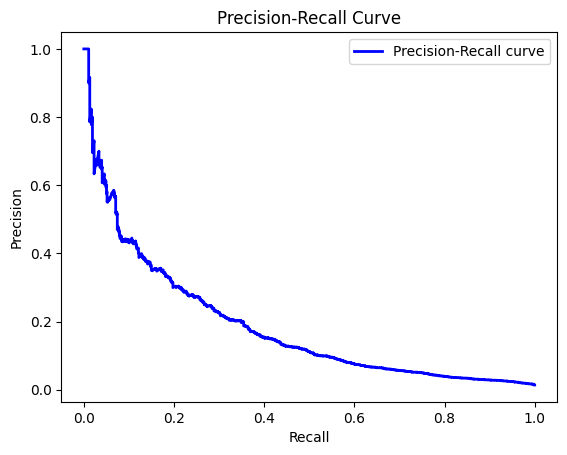

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
param_grid = {
    'n_estimators': [10, 50, 100, 200],  
    'max_depth': [None, 10, 20, 30, 40]  
}
clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_filtrado, y_train)
best_params = grid_search.best_params_
logging.info(f"Best parameters: {best_params}")
clf_optimo = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], random_state=42)
clf_optimo.fit(X_filtrado, y_train)

y_scores = clf_optimo.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

y_pred = clf_optimo.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
logging.info(f"Confusion Matrix:\n{conf_matrix}")

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
logging.info(f"Metrics:\nAccuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

auc_precision_recall = auc(recall, precision)
logging.info(f"AUC for Precision-Recall Curve: {auc_precision_recall:.2f}")